In [291]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from models.embed import DataEmbedding
from models.Autoformer_EncDec import series_decomp, series_decomp_multi
from models.MICN import Model
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

# ACB 7:3

In [292]:
data = pd.read_csv("/content/ACB.VN-BaoCao.csv")

In [293]:
# Preprocess data
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.sort_values('Date')
data.dropna(inplace=True)
close_price = data['Close'].values

In [294]:
# Split data into train and test sets
train_size = int(len(close_price) * 0.7)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))
train_data, test_data = scaled_data[:train_size], scaled_data[train_size-1:]

In [295]:
def create_sequences(data):
    x, y = [], []
    for i in range(1, len(data)):
        x.append(data[i-1:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Create sequences for training data
x_train, y_train = create_sequences(train_data)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.unsqueeze(2)

# Create sequences for test data
x_test, _ = create_sequences(test_data)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_test = x_test.unsqueeze(2)

# Extract y_test from close_price
y_test = close_price[train_size:]

In [296]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define configurations and model parameters
class Configs:
    def __init__(self):
        self.enc_in = 1  # Input dimension
        self.d_model = 128  # Model dimension
        self.embed = 'timeF'  # Embedding dimension
        self.freq = 'd'  # Frequency for positional encoding
        self.dropout = 0.1  # Dropout rate
        self.n_heads = 8  # Number of attention heads
        self.d_layers = 3  # Number of encoder layers
        self.pred_len = 90  # Prediction length
        self.seq_len = seq_length  # Sequence length

configs = Configs()
model = Model(configs)
model.to(device)

Model(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=128, bias=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=Tru

In [297]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(x_train.to(device), None, x_test.to(device), None)
    loss = criterion(output, y_train.to(device))
    loss.backward()
    optimizer.step()


In [298]:
# Predict on the test data
model.eval()
y_pred_test = []

with torch.no_grad():
    for i in range(len(x_test)):
        input_seq = x_test[i].unsqueeze(0).to(device)
        pred = model(input_seq, None, input_seq, None)
        y_pred_test.append(pred.cpu().numpy().flatten())

# Convert list to numpy array
y_pred_test = np.concatenate(y_pred_test)

# Inverse transform test predictions
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Evaluate the predictions on the test set
y_test_true = y_test

# Calculate test metrics
mape_test = mean_absolute_percentage_error(y_test_true, y_pred_test)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_pred_test))
msle_test = mean_squared_log_error(y_test_true, y_pred_test)

# Print test results
print('---------TEST----------')
print("MAPE:", round(mape_test, 3))
print("MAE:", round(mae_test, 3))
print("RMSE:", round(rmse_test, 3))
print("MSLE:", round(msle_test, 3))
print('-------------------')

---------TEST----------
MAPE: 0.066
MAE: 1438.314
RMSE: 2186.285
MSLE: 0.01
-------------------


In [299]:
# Predict next 90 days
model.eval()
y_pred_next_90 = []
input_seq = x_test[-1].unsqueeze(0).to(device)  # Start with the last sequence from the test set

with torch.no_grad():
    for _ in range(configs.pred_len):
        pred = model(input_seq, None, input_seq, None)
        y_pred_next_90.append(pred.item())
        new_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(2)), dim=1)  # Slide the window
        input_seq = new_seq

# Inverse transform predictions
y_pred_next_90 = scaler.inverse_transform(np.array(y_pred_next_90).reshape(-1, 1))


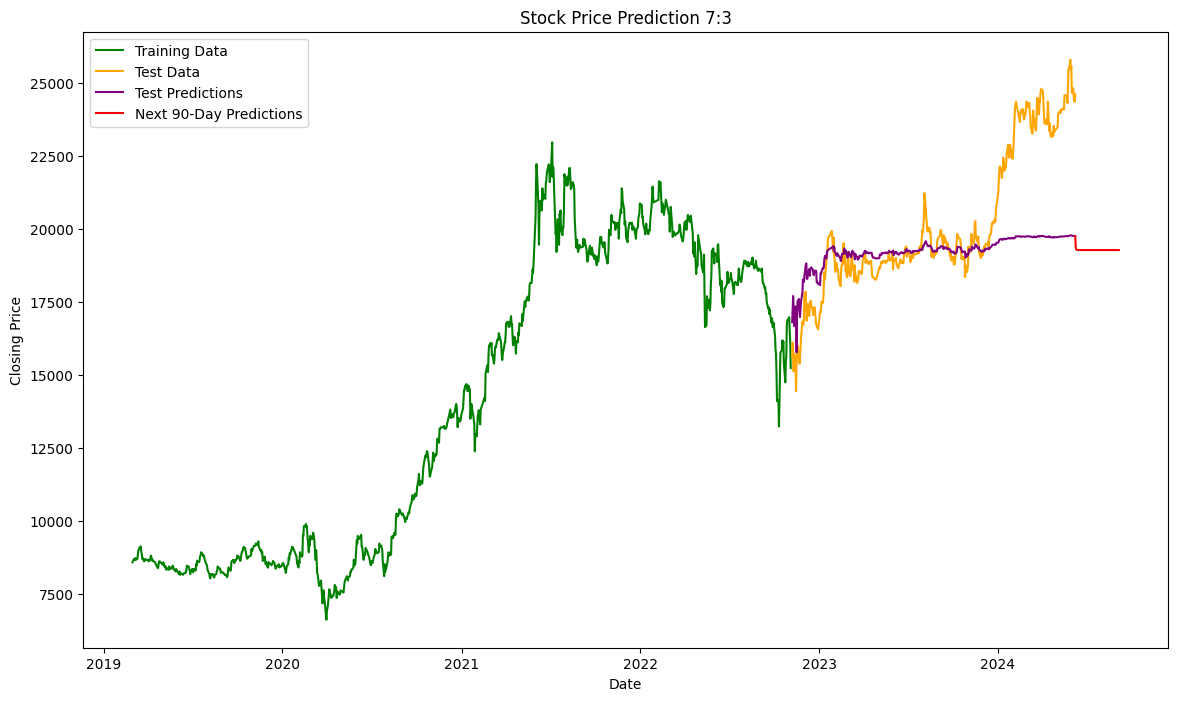

In [300]:
import matplotlib.pyplot as plt

# Plotting the training data, test data, and predictions

plt.figure(figsize=(14, 8))

# Highlight the training data
plt.plot(data['Date'][:train_size], data['Close'][:train_size], color='green', label='Training Data')

# Highlight the test data
plt.plot(data['Date'][train_size:], data['Close'][train_size:], color='orange', label='Test Data')

# Plot the test predictions
plt.plot(data['Date'][train_size:train_size+len(y_pred_test)], y_pred_test, color='purple', label='Test Predictions')

# Plot the predictions next 90 days
pred_dates = pd.date_range(start=data['Date'].iloc[-1], periods=90, freq='D')
plt.plot(pred_dates, y_pred_next_90, color='red', label='Next 90-Day Predictions')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Prediction 7:3')
plt.legend()
plt.show()



# ACB 8:2

In [301]:
data = pd.read_csv("/content/ACB.VN-BaoCao.csv")

In [302]:
# Preprocess data
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.sort_values('Date')
data.dropna(inplace=True)
close_price = data['Close'].values

In [303]:
# Split data into train and test sets
train_size = int(len(close_price) * 0.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))
train_data, test_data = scaled_data[:train_size], scaled_data[train_size-1:]

In [304]:
def create_sequences(data):
    x, y = [], []
    for i in range(1, len(data)):
        x.append(data[i-1:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Create sequences for training data
x_train, y_train = create_sequences(train_data)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.unsqueeze(2)

# Create sequences for test data
x_test, _ = create_sequences(test_data)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_test = x_test.unsqueeze(2)

# Extract y_test from close_price
y_test = close_price[train_size:]

In [305]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define configurations and model parameters
class Configs:
    def __init__(self):
        self.enc_in = 1  # Input dimension
        self.d_model = 128  # Model dimension
        self.embed = 'timeF'  # Embedding dimension
        self.freq = 'd'  # Frequency for positional encoding
        self.dropout = 0.1  # Dropout rate
        self.n_heads = 8  # Number of attention heads
        self.d_layers = 3  # Number of encoder layers
        self.pred_len = 90  # Prediction length
        self.seq_len = seq_length  # Sequence length

configs = Configs()
model = Model(configs)
model.to(device)

Model(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=128, bias=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=Tru

In [306]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(x_train.to(device), None, x_test.to(device), None)
    loss = criterion(output, y_train.to(device))
    loss.backward()
    optimizer.step()


In [307]:
# Predict on the test data
model.eval()
y_pred_test = []

with torch.no_grad():
    for i in range(len(x_test)):
        input_seq = x_test[i].unsqueeze(0).to(device)
        pred = model(input_seq, None, input_seq, None)
        y_pred_test.append(pred.cpu().numpy().flatten())

# Convert list to numpy array
y_pred_test = np.concatenate(y_pred_test)

# Inverse transform test predictions
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Evaluate the predictions on the test set
y_test_true = y_test

# Calculate test metrics
mape_test = mean_absolute_percentage_error(y_test_true, y_pred_test)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_pred_test))
msle_test = mean_squared_log_error(y_test_true, y_pred_test)

# Print test results
print('---------TEST----------')
print("MAPE:", round(mape_test, 3))
print("MAE:", round(mae_test, 3))
print("RMSE:", round(rmse_test, 3))
print("MSLE:", round(msle_test, 3))
print('-------------------')

---------TEST----------
MAPE: 0.151
MAE: 3363.858
RMSE: 3922.045
MSLE: 0.037
-------------------


In [308]:
# Predict next 90 days
model.eval()
y_pred_next_90 = []
input_seq = x_test[-1].unsqueeze(0).to(device)  # Start with the last sequence from the test set

with torch.no_grad():
    for _ in range(configs.pred_len):
        pred = model(input_seq, None, input_seq, None)
        y_pred_next_90.append(pred.item())
        new_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(2)), dim=1)  # Slide the window
        input_seq = new_seq

# Inverse transform predictions
y_pred_next_90 = scaler.inverse_transform(np.array(y_pred_next_90).reshape(-1, 1))


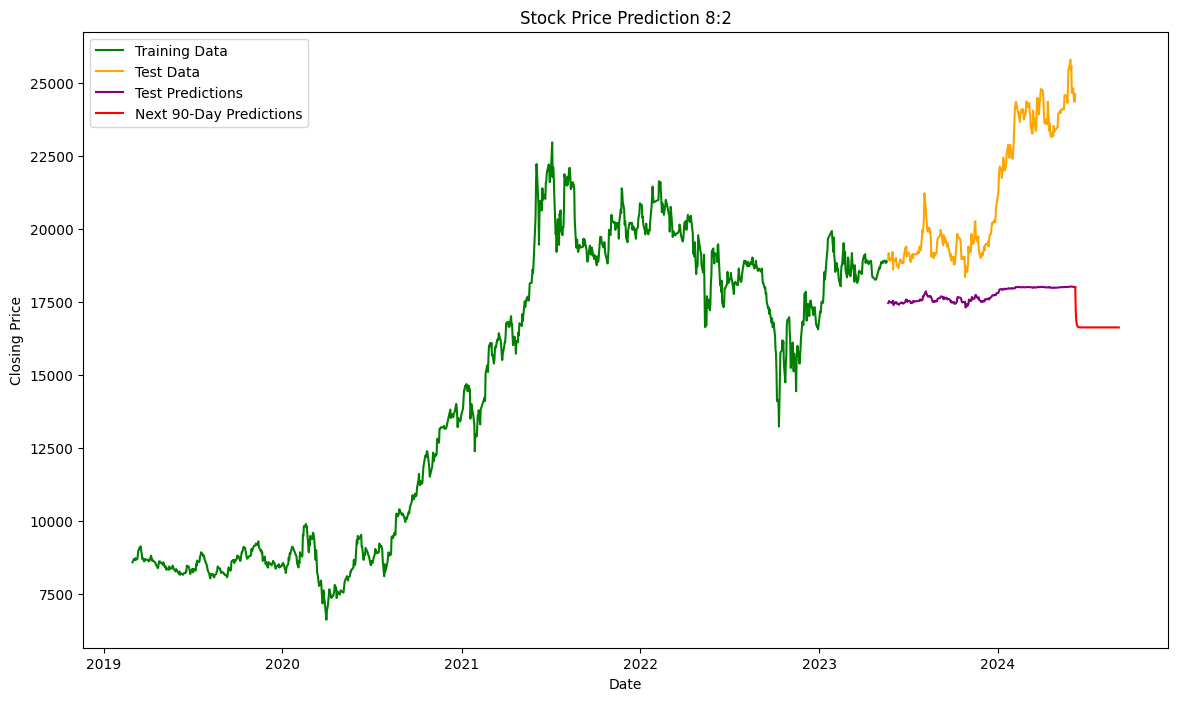

In [309]:
import matplotlib.pyplot as plt

# Plotting the training data, test data, and predictions

plt.figure(figsize=(14, 8))

# Highlight the training data
plt.plot(data['Date'][:train_size], data['Close'][:train_size], color='green', label='Training Data')

# Highlight the test data
plt.plot(data['Date'][train_size:], data['Close'][train_size:], color='orange', label='Test Data')

# Plot the test predictions
plt.plot(data['Date'][train_size:train_size+len(y_pred_test)], y_pred_test, color='purple', label='Test Predictions')

# Plot the predictions next 90 days
pred_dates = pd.date_range(start=data['Date'].iloc[-1], periods=90, freq='D')
plt.plot(pred_dates, y_pred_next_90, color='red', label='Next 90-Day Predictions')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Prediction 8:2')
plt.legend()
plt.show()



# ACB 9:1

In [310]:
data = pd.read_csv("/content/ACB.VN-BaoCao.csv")

In [311]:
# Preprocess data
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.sort_values('Date')
data.dropna(inplace=True)
close_price = data['Close'].values

In [312]:
# Split data into train and test sets
train_size = int(len(close_price) * 0.9)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.reshape(-1, 1))
train_data, test_data = scaled_data[:train_size], scaled_data[train_size-1:]

In [313]:
def create_sequences(data):
    x, y = [], []
    for i in range(1, len(data)):
        x.append(data[i-1:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Create sequences for training data
x_train, y_train = create_sequences(train_data)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.unsqueeze(2)

# Create sequences for test data
x_test, _ = create_sequences(test_data)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_test = x_test.unsqueeze(2)

# Extract y_test from close_price
y_test = close_price[train_size:]

In [314]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define configurations and model parameters
class Configs:
    def __init__(self):
        self.enc_in = 1  # Input dimension
        self.d_model = 128  # Model dimension
        self.embed = 'timeF'  # Embedding dimension
        self.freq = 'd'  # Frequency for positional encoding
        self.dropout = 0.1  # Dropout rate
        self.n_heads = 8  # Number of attention heads
        self.d_layers = 3  # Number of encoder layers
        self.pred_len = 90  # Prediction length
        self.seq_len = seq_length  # Sequence length

configs = Configs()
model = Model(configs)
model.to(device)

Model(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=3, out_features=128, bias=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=Tru

In [315]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(x_train.to(device), None, x_test.to(device), None)
    loss = criterion(output, y_train.to(device))
    loss.backward()
    optimizer.step()


In [316]:
# Predict on the test data
model.eval()
y_pred_test = []

with torch.no_grad():
    for i in range(len(x_test)):
        input_seq = x_test[i].unsqueeze(0).to(device)
        pred = model(input_seq, None, input_seq, None)
        y_pred_test.append(pred.cpu().numpy().flatten())

# Convert list to numpy array
y_pred_test = np.concatenate(y_pred_test)

# Inverse transform test predictions
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Evaluate the predictions on the test set
y_test_true = y_test

# Calculate test metrics
mape_test = mean_absolute_percentage_error(y_test_true, y_pred_test)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_pred_test))
msle_test = mean_squared_log_error(y_test_true, y_pred_test)

# Print test results
print('---------TEST----------')
print("MAPE:", round(mape_test, 3))
print("MAE:", round(mae_test, 3))
print("RMSE:", round(rmse_test, 3))
print("MSLE:", round(msle_test, 3))
print('-------------------')

---------TEST----------
MAPE: 0.193
MAE: 4513.602
RMSE: 4786.054
MSLE: 0.052
-------------------


In [317]:
# Predict next 90 days
model.eval()
y_pred_next_90 = []
input_seq = x_test[-1].unsqueeze(0).to(device)  # Start with the last sequence from the test set

with torch.no_grad():
    for _ in range(configs.pred_len):
        pred = model(input_seq, None, input_seq, None)
        y_pred_next_90.append(pred.item())
        new_seq = torch.cat((input_seq[:, 1:], pred.unsqueeze(0).unsqueeze(2)), dim=1)  # Slide the window
        input_seq = new_seq

# Inverse transform predictions
y_pred_next_90 = scaler.inverse_transform(np.array(y_pred_next_90).reshape(-1, 1))


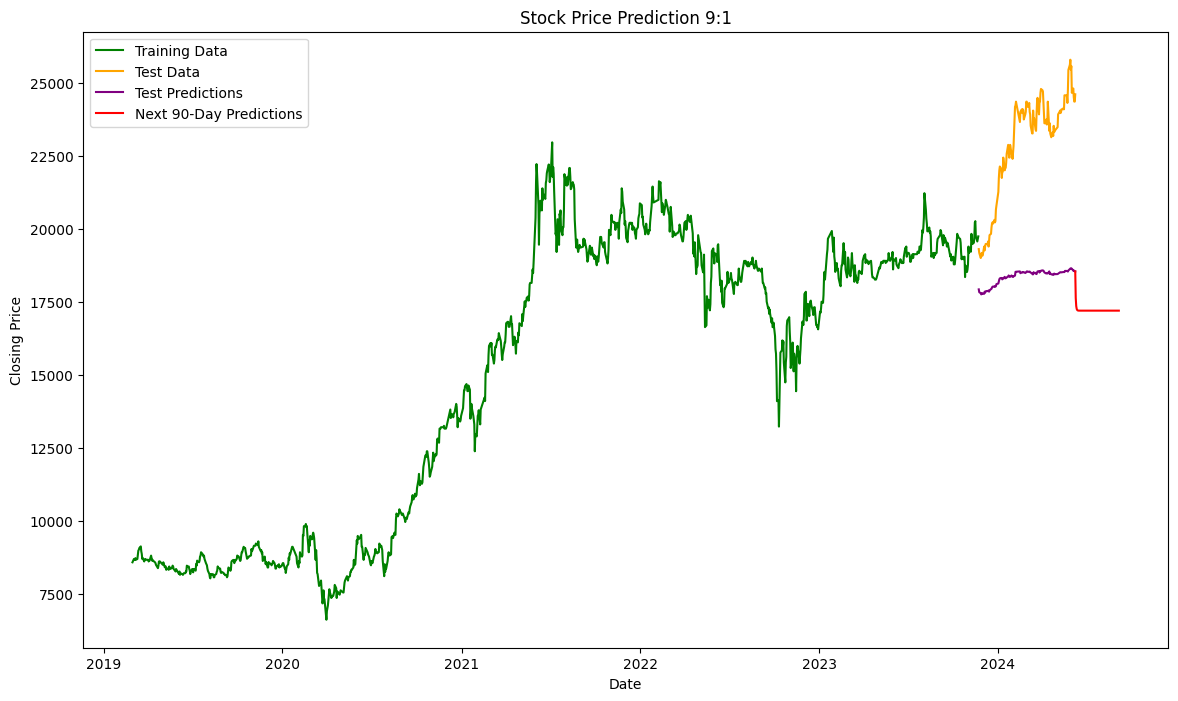

In [318]:
import matplotlib.pyplot as plt

# Plotting the training data, test data, and predictions

plt.figure(figsize=(14, 8))

# Highlight the training data
plt.plot(data['Date'][:train_size], data['Close'][:train_size], color='green', label='Training Data')

# Highlight the test data
plt.plot(data['Date'][train_size:], data['Close'][train_size:], color='orange', label='Test Data')

# Plot the test predictions
plt.plot(data['Date'][train_size:train_size+len(y_pred_test)], y_pred_test, color='purple', label='Test Predictions')

# Plot the predictions next 90 days
pred_dates = pd.date_range(start=data['Date'].iloc[-1], periods=90, freq='D')
plt.plot(pred_dates, y_pred_next_90, color='red', label='Next 90-Day Predictions')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Prediction 9:1')
plt.legend()
plt.show()

